# Training Domain-informed Neural Network model

A Domain-informed Neural Network (DiNN) model is implemented and trained on simulated S2 patterns using Pytorch.

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

torch.set_default_dtype(torch.float64)

import sklearn

# torch.__version__

In [18]:
from torch.nn import functional as F
import torch.nn.init as init

class GraphConstrained(torch.nn.Module):

    def __init__(self, in_features: int, out_features: int,
                 masking = None, 
                 bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # self.masking = torch.Tensor(masking, device = device)
        self.register_buffer('masking', torch.tensor(masking, **factory_kwargs))
        self.weight = torch.nn.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = torch.nn.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        masked_weight  = self.weight * self.masking

        return F.linear(input, masked_weight, self.bias)




class FG_Squircular_to_disk(torch.nn.Module):
    def __init__(self, scale):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.scale = scale


    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        # return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

        numerator = torch.sqrt(torch.square(x[:,0])+torch.square(x[:,1]) - torch.square(x[:,0] * x[:,1]))
        denominator = torch.sqrt(torch.square(x[:,0])+torch.square(x[:,1]))
        scaling = self.scale * torch.reshape(numerator/denominator, [-1,1])
        return x * scaling




    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'

## Simulate S2 patterns using empirical LCE model 

In [3]:
# Basic Config 
N_PATTERNS = int(1e6)
TPC_RADIUS = 66.4 # cm
N_ELECTRONS = 100 # not used for training
SECONDARY_YIELD = 350 # PE/e
SPE_RESOLUTION = 0.05 # 5%


# parameters for LCE model
BEST_FIT = (1.17985513e-02,  # lce_0
            2.39099129e+00,  # p
            1.03367572e+01,  # d
            -6.77171875e-07, # a
            9.86493009e-05)  # b


# photosensor positions
PMT_POSITIONS = pd.read_csv("./DiNN/PMT_POSITIONS.csv").to_numpy()

In [4]:
# Empirical LCE model

def lce_model(rho, lce_0, p, d, a, b):
    """Model of the light collection efficiency
    """
    return lce_0 * (1 - b)/(1 + (rho/d)**2)**p + a * rho + b

In [5]:
# utilities for simulating S2 patterns

def get_random_points_in_circle(n_patterns = N_PATTERNS,
                                tpc_radius = TPC_RADIUS):
    """Get random points in a circle of radius tpc_radius
    
    Returns array (n_patterns, 2)
    """
    r = tpc_radius * np.sqrt(np.random.uniform(size=n_patterns))
    theta = 2 * np.pi * np.random.uniform(size=n_patterns)
    return np.vstack((r * np.cos(theta), r * np.sin(theta))).T

def get_hitpatterns(n_patterns = N_PATTERNS, 
                    n_electrons = N_ELECTRONS,
                    secondary_yield = SECONDARY_YIELD,
                    spe_resolution = SPE_RESOLUTION,
                    sensor_positions = PMT_POSITIONS,
                    fluctuate = True):
    """
    Simulate S2 patterns.
    
    Returns tuple (true S2 position, S2 patterns)
    """
    points = get_random_points_in_circle(n_patterns) # (n_patterns, 2), cm
    
    n_pmts = sensor_positions.shape[0]
    n_points = points.shape[0]
    
    # Compute all combinations of points and PMT positions
    points_big = np.repeat(points, n_pmts, axis=0).reshape(-1, 2)
    pmt_positions_big = np.tile(PMT_POSITIONS.flatten(), n_points).reshape(-1, 2)
    distances = np.sqrt(np.sum(np.power(points_big - pmt_positions_big,
                                        2),
                               axis=1).reshape(n_points,
                                               n_pmts))
    # distances[1, 2] # first index is point, second index is pmt
    
    
    lce = lce_model(distances, *BEST_FIT) # (n_points, n_pmts)
    
    if fluctuate == False:
        return lce
    
    lce *= n_electrons * SECONDARY_YIELD
    
    return (points, np.random.poisson(lce) * np.random.normal(loc=1,
                                                     scale=spe_resolution,
                                                     size=lce.shape).reshape(lce.shape))

In [33]:
true = []
hit_patterns = []
for i in range(7):
    true_, hit_patterns_ = get_hitpatterns(n_patterns=100000 ,fluctuate=True)
    true.append(true_)
    hit_patterns.append(hit_patterns_)

true = np.concatenate(true)
hit_patterns = np.concatenate(hit_patterns)

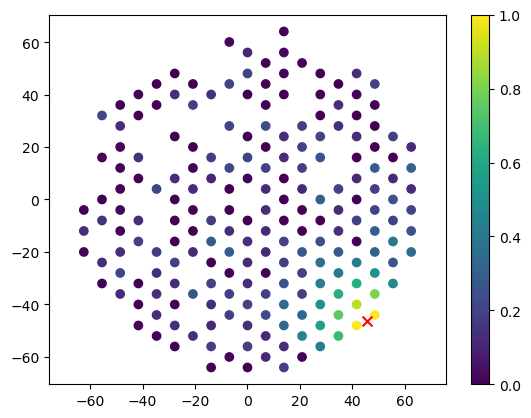

In [34]:
index = 7

plt.scatter(*PMT_POSITIONS.T, c=hit_patterns[index],
           norm=colors.LogNorm(vmin=1,
                                 vmax=hit_patterns[index].max())
           )

plt.scatter(true[index,0], true[index,1], color = "red", marker = "x", s = 50)
plt.xlim(-TPC_RADIUS, TPC_RADIUS)
plt.ylim(-TPC_RADIUS, TPC_RADIUS)
plt.axis("equal")
plt.colorbar()

In [35]:
# normalize

patterns = hit_patterns[:,:253]
patterns = patterns / np.max(patterns, axis = 1).reshape(-1, 1)
patterns = patterns.reshape(-1,253)
patterns.shape

(700000, 253)

In [36]:
# spilting into training/validation/testing set

train_size = 500000
test_size = 100000

positions = true[:,0:2]

x_train_pos = patterns[:train_size]
y_train_pos = positions[:train_size]
x_val_pos = patterns[train_size: train_size + test_size]
y_val_pos = positions[train_size: train_size + test_size]
x_test_pos = patterns[train_size + test_size: train_size + 2 * test_size]
y_test_pos = positions[train_size + test_size: train_size + 2 * test_size]


In [37]:
class S2PosRecDataset(Dataset):
    def __init__(self, hp, pos):
        self.hp = hp
        self.pos = pos

    def __len__(self):
        return len(self.hp)

    def __getitem__(self, idx):
        one_hp = self.hp[idx]
        one_pos = self.pos[idx]
        return one_hp, one_pos

train_data = S2PosRecDataset(x_train_pos, y_train_pos)
val_data = S2PosRecDataset(x_val_pos, y_val_pos)

## Build DiNN model

In [11]:
# utilities for assigning positions to neurons in graph constraint layers

def radialarrange(radius, number, start = 0):
    angle = 2 * np.pi * np.linspace(0, 1., number, endpoint = False) + start * np.pi
    points = np.zeros((number, 2))
    points[:,0] = np.cos(angle) * radius
    points[:,1] = np.sin(angle) * radius
    return points

def adj_from_coordinate(points1, points2, threshold = 20.):
    from sklearn.metrics import euclidean_distances
    points = np.concatenate([points1, points2])
    distances = euclidean_distances(points)
    distances[distances <= threshold] = 1.
    distances[distances > threshold] = 0.
    adj = distances[:len(points1), -len(points2):]
    return adj

def layer_points(PMT_number, r_distance, ring_num):
    layer_radius = [ i * r_distance for i in range(ring_num)]
    points = np.zeros((0,2))
    for i in range(ring_num):
        points = np.concatenate([points, radialarrange(layer_radius[i], PMT_number[i], start = 0)])
    
    return points

In [12]:
# generate adjacency matrix for each layer

PMT_number = [1, 6, 12, 18, 24, 30, 36, 42, 48]
R_distances = [8., 9., 10.5, 13, 16, 21]
ring_num = [9, 8, 7, 6, 5, 4]

points = [PMT_POSITIONS,]
for i in range(len(ring_num)):
    points.append(layer_points(PMT_number, R_distances[i], ring_num[i]))
    
adj = []
for i in range(len(ring_num)):
    adj.append(adj_from_coordinate(points[i], points[i + 1], threshold = 30.))

/tmp/ipykernel_11040/4200396139.py:12: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8


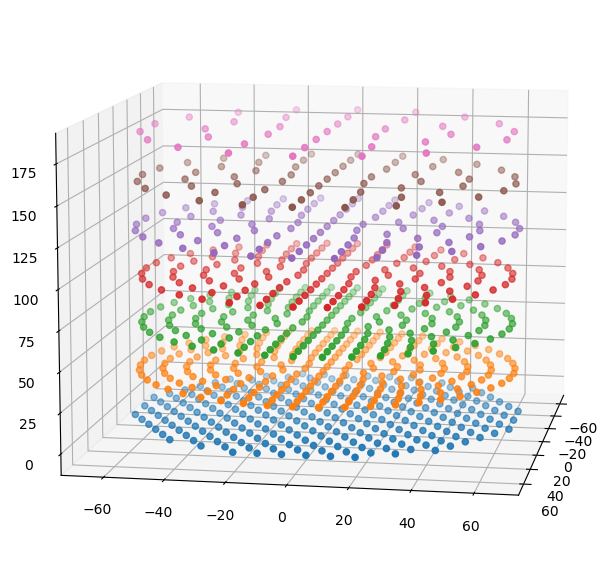

In [13]:
# Show the assigned positions along with the top photosensor array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (7, 9))
ax = fig.add_subplot(111, projection='3d')

for i,d in enumerate(points):
    ax.scatter(d[:,0], d[:,1], zs = i * 30.)
    
    
ax.azim = 10
ax.dist = 8
ax.elev = 10    
plt.show()

In [14]:
for p in points:
    print(p.shape)

(253, 2)
(217, 2)
(169, 2)
(127, 2)
(91, 2)
(61, 2)
(37, 2)


In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class DiNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            GraphConstrained(253, 217, adj[0].T),
            nn.ReLU(),
            GraphConstrained(217, 169, adj[1].T),
            nn.ReLU(),
            GraphConstrained(169, 127, adj[2].T),
            nn.ReLU(),
            GraphConstrained(127, 91, adj[3].T),
            nn.ReLU(),
            GraphConstrained(91, 61, adj[4].T),
            nn.ReLU(),
            GraphConstrained(61, 37, adj[5].T),
            nn.ReLU(),
            nn.Linear(37, 20),
            nn.ReLU(),
            nn.Linear(20, 2),
            nn.Tanh(),
            FG_Squircular_to_disk(67.)
        )

    def forward(self, x):
        # x = self.flatten(x)
        pred = self.model(x)
        return pred

model = DiNN().to(device)
print(model)

Using cuda device
DiNN(
  (model): Sequential(
    (0): GraphConstrained()
    (1): ReLU()
    (2): GraphConstrained()
    (3): ReLU()
    (4): GraphConstrained()
    (5): ReLU()
    (6): GraphConstrained()
    (7): ReLU()
    (8): GraphConstrained()
    (9): ReLU()
    (10): GraphConstrained()
    (11): ReLU()
    (12): Linear(in_features=37, out_features=20, bias=True)
    (13): ReLU()
    (14): Linear(in_features=20, out_features=2, bias=True)
    (15): Tanh()
    (16): FG_Squircular_to_disk()
  )
)


## Train the DiNN model

In [38]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

In [41]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


history = {'loss':[], 'val_loss':[]}

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)


        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        if batch == 0:
            history['loss'].append(loss)

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    print(f"Test Error:Avg loss: {test_loss:>8f} \n")
    history['val_loss'].append(test_loss)

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1294.212149  [    0/500000]
loss: 1043.364017  [ 3200/500000]
loss: 986.769695  [ 6400/500000]
loss: 163.906064  [ 9600/500000]
loss: 43.255101  [12800/500000]
loss: 18.761392  [16000/500000]
loss: 10.085889  [19200/500000]
loss: 9.795247  [22400/500000]
loss: 7.421166  [25600/500000]
loss: 4.142202  [28800/500000]
loss: 7.451569  [32000/500000]
loss: 7.178479  [35200/500000]
loss: 6.350575  [38400/500000]
loss: 6.980335  [41600/500000]
loss: 6.623303  [44800/500000]
loss: 4.115343  [48000/500000]
loss: 4.086859  [51200/500000]
loss: 3.904360  [54400/500000]
loss: 4.133946  [57600/500000]
loss: 4.669872  [60800/500000]
loss: 3.401490  [64000/500000]
loss: 2.961527  [67200/500000]
loss: 3.616191  [70400/500000]
loss: 3.337770  [73600/500000]
loss: 3.136764  [76800/500000]
loss: 3.227862  [80000/500000]
loss: 3.153642  [83200/500000]
loss: 2.859226  [86400/500000]
loss: 3.444843  [89600/500000]
loss: 2.864134  [92800/500000]
loss: 2.436603  [

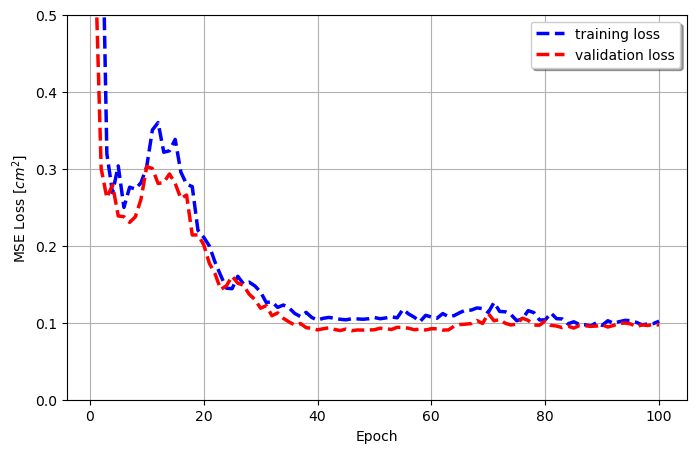

In [43]:
x = np.linspace(1, epochs, epochs)
val_loss = history['val_loss']
loss = history['loss']


fig_sig= plt.figure(figsize = (8,5))

#--------------------------------------------------------------------->
plt.plot(x,loss,label='training loss', color='blue', linestyle = '--', lw=2.5)
plt.plot(x,val_loss,label='validation loss', color='red', linestyle = '--', lw=2.5)
#-------------------------------------------------------------------->
# plt.title(r'Fig 3: Training Process', fontsize = 20)
# plt.xlim(0,epochs)
plt.ylim(0, 0.5)

plt.xlabel('Epoch')
plt.ylabel('MSE Loss [$cm^2$]')
plt.grid(True)

legend = plt.legend(loc='upper right', shadow=True)

plt.show()

In [45]:
pred_pos = model(torch.tensor(x_test_pos).to(device))
test_pos = np.array(y_test_pos).reshape(-1,2)

In [49]:
pred_pos = pred_pos.to('cpu').detach().numpy()

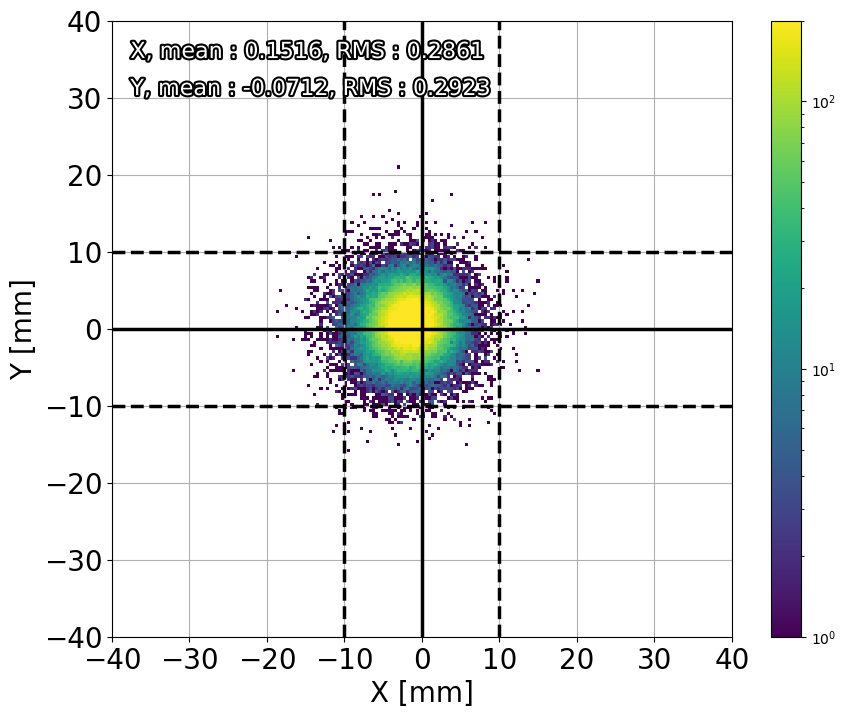

In [50]:
import matplotlib.patheffects as path_effects

fig_sig= plt.figure(figsize = (10,8))

#--------------------------------------------------------------------->
plt.hist2d((pred_pos[:,0]-test_pos[:,0]) * 10.,  (pred_pos[:,1]-test_pos[:,1]) * 10., range=((-40, 40), (-40, 40)), bins=(200, 200), 
           norm=colors.LogNorm( vmin=1, vmax=200))
plt.colorbar()

#-------------------------------------------------------------------->

plt.xlim(-40, 40)
plt.ylim(-40, 40)

plt.xlabel(r'X [mm]', fontsize =20)
plt.ylabel(r'Y [mm]', fontsize =20)
plt.grid(True)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.axvline(0, color='black', linestyle='-', linewidth = 2.5)
plt.axvline(-10, color='black', linestyle='--', linewidth = 2.5)
plt.axvline(10, color='black', linestyle='--', linewidth = 2.5)

plt.axhline(0, color='black', linestyle='-', linewidth = 2.5)
plt.axhline(-10, color='black', linestyle='--', linewidth = 2.5)
plt.axhline(10, color='black', linestyle='--', linewidth = 2.5)

bias = np.sum(test_pos-pred_pos,axis = 0) / len(y_test_pos)
rms = np.std(test_pos-pred_pos,axis = 0)

text_X= plt.text(0.03,0.95,"X, mean : %0.4f, RMS : %0.4f"%(bias[0],rms[0] ), 
         transform = plt.gca().transAxes, ha = "left", va="center" , fontsize=16, c="w")
text_X.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'),
                       path_effects.Normal()])
text_Y=plt.text(0.03,0.89,"Y, mean : %0.4f, RMS : %0.4f"%(bias[1],rms[1] ), 
         transform = plt.gca().transAxes, ha = "left", va="center" , fontsize=16, c="w")
text_Y.set_path_effects([path_effects.Stroke(linewidth=3, foreground='k'),
                       path_effects.Normal()])

plt.show()

Unexpected bias here but at least the nn works :(